# Chapter 01. 금융 데이터로 소득구간 예측하기

## 실습 가이드
1. 데이터를 다운로드하여 Colab에 불러옵니다.
2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
3. 코드는 위에서부터 아래로 순서대로 실행합니다.
4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## Step 0. 금융 데이터 소개 및 예측 모델 개요 
고객 소득구간 예측문제는 금융 데이터 분석에서 가장 중요한 문제 중 하나라고 할 수 있습니다.
분석에 들어가기 앞서 2가지 사항을 짚어보도록 하겠습니다.

### <b> 금융 데이터의 속성</b>
금융 데이터는 주로 아래의 특성을 띄게 됩니다.
- 1) <b>이종(heterogeneous) 데이터의 결합</b>: 데이터의 원천·형태·스케일 등이 서로 다른 성격을 가짐
- 2) <b>분포의 편향성(skewedness)</b>: 예측값과 정답이 멀리 떨어져 있으면 학습 결과의 편향(bias)이 높을 수 있음
- 3) <b>분류 레이블의 불명확성</b>: 소득구간·신용등급·상품종류 등은 비즈니스 로직을 포함하므로 분류가 임의적 → 분석가의 해석력이 중요
- 4) <b>변수의 다중공선성(multicollinearity)</b>: 변수간 상호의존이나 상관관계가 강하게 나타날 수 있음
- 5) <b>변수의 비선형성</b>: 변수의 영향력이 선형적이지 않을 수 있음, e.g.) 나이가 소득에 미치는 영향은?
- 그 외 현실적인 규제·수집·저장 등의 한계 때문에 데이터가 불완전(missing, truncated, censored)할 수 있음

1) 카드 소비 데이터 : 어떤 고객이, 스타벅스 명동지점, 15000원을 소비함

소비금액 -- continuous, 소비장소(가맹정 명칭--txt, 가맹정 위치-zip code, nomial, 상권 -- txt, 행정동, 법정동, 가맹정 업종 식음료, 일반음식점, 휴게소 -- txt, numeric), 소비시각(연월일, 주말구분--binary)

고객 -- 나이, 성별, 신용등급(1~9 등급, ordinal), 추정 연소득, 월 평균 잔액, 월 평균 소비액, 대출잔액 // 비금융정보(모바일앱 사용여부, 쿠폰 사용여부, 마지막 로그인, ...), 신판 구분, 할부 구분, 해외가맹점 구분, 개인 / 가족, 주력 카드 여부, ...  ==> Categorical Variable

c.f.) 이미지? ==> 픽셀(0, 1) 28*28 일정한 signal, 일정한 scale 
- 반면 금융데이터는: signal-to-noise 비율이 높음 ==> 데이터 처리, 정제 ==> 딥러닝 적용 가능? X


2) skwewed? mean < median < mode

    ==> log transformation
    ==> binning (구간 나눠서 처리)

3) 소득 [0, 10] (단위: 천만원)
    
    [0, 1], [1, 2], ... [9, 10] => 10개 등급 => 클래스간 분포가 균등하다면, 정확도 : 10%
    [0, 2], [2, 4], ... [8, 10] => 5개 등급 => 3등급에 데이터가 과다하게 몰려있다면 => 학습 없이 3등급으로 찍으면 정확도 상승할 수 밖에 없음
    [0, 3], [3, 4], [4, 5], ... [7, 10] => 5개 등급 => 클래스간 균등하지 않은 범위 => 모든 가능성에 장점과 단점을 고려할 줄 알아야 함
    ==> 분석가의 역량에 달려있음
    
4), 5) 변수의 다중공선성 : 변수간 상호의존이나 상관관계가 강하게 나타날 수 있음
나이(continuous), 성별(0,1) => 소득

    univariate 비선형성
    나이가 ++ ==> 소득 ++
    나이[0, 50] ++ --> 소득 ++
    나이 [50, 99] ++ --> 소득 --> XAI(설명가능한 머신러닝)
    
    
    성별 ++ ==> 소득 --
    나이 ++ & 성별 ++ ==> 소득 ?? --> XAI(설명가능한 머신러닝)

### <b>다중분류와 소득구간 예측</b>
예측할 클래스(레이블 혹은 레벨이라고도 합니다)가 3개 이상인 경우를 다중분류 문제라고 합니다. 단순하게는 Multiclass classification, 회귀방법론을 쓴다면 Multinomial logistic regression 이라는 명칭으로 불립니다. 클래스간 위계관계(포함관계)는 동등하다고 가정하겠습니다. 

소득구간 예측은 전형적인 다중분류 문제입니다. 분석에 앞서 다음과 같은 사항을 생각해 봅시다.
- 1) <b> 클래스간 구분이 명확하지 않을 경우</b>: 소득구간 구분은 어떻게 지어야 하며, 클래스는 몇 개로 결정해야 할까요? 
- 2) <b>클래스간 구분에 순서가 있을 경우</b>: 정확하게 말하자면 각 소득구간은 순서가 있는(ordinal) 클래스로 보아야 할 것입니다.
- 3) <b>특정 클래스에 해당하는 값이 부족할 경우</b>: 고소득 구간 고객 수와 중소득 구간 고객의 수가 현저히 차이가 날 때 어떻게 해결할까요?

다중분류 문제는 이진분류 대비 아래와 같은 추가 고려사항이 있습니다.
- 1) <b>모델 구현할 때 주의사항</b>: 변수의 원-핫-인코딩 처리, 목적함수의 결정 등
- 2) <b>결과 해석할 때 주의사항</b>: 정확도(Accuracy), F1 스코어, Confusion Matrix 등
- 실제 분석에서 자세히 다루도록 하겠습니다.

### <b>학습목표</b>
- 1) 이진분류·다중분류 모델의 이해
- 2) 선형 기반·트리 기반 분류모델의 이해
- 3) 변수 처리 방법에 대한 이해
- 4) 분류모델 결과를 해석하는 방법 습득
- 5) 평가결과를 바탕으로 모델을 개선하는 방법 습득

- 출제자: 최민정 강사

## Step 1. 예측할 데이터 불러오기

### 데이터 소개
 
- 이번 주제는 US Census Bureau에서 수집하고 UCI에서 배포한 US Adult Income 데이터셋에 강사가 자체 제작한 모의 변수를 추가·수정한 데이터를 사용합니다.
- 첫번째로 사용할 데이터는 US Adult Income 데이터셋이며 컬럼은 아래와 같습니다.
 
 
- `age` : 나이
- `workclass`: 직업구분
- `fnlwgt` : 샘플로서의 대표성 값
- `education`: 교육수준
- `education.num`: 교육수준(numerically coded)
- `marital.status`: 혼인상태
- `occupation` : 직업
- `relationship`: 가족관계
- `race`: 인종
- `sex`: 성별
- `capital.gain`: 자본이득
- `capital.loss`: 자본손실
- `hours.per.week`: 주당 근로시간
- `income` : 소득 구분
 
원 데이터 출처: https://archive.ics.uci.edu/ml/datasets/adult

### 문제 01. 데이터 불러오기

In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
datapath = 'https://github.com/mchoimis/financialML/raw/main/income/'
df = pd.io.parsers.read_csv(datapath + 'income.csv')
df.head(3)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K


### 문제 02. 데이터 미리보기

In [3]:
# 데이터 형태 확인

df.shape

(32561, 15)

In [4]:
df.info() # NA값은 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
df['fnlwgt'][:5]

0     77053
1    132870
2    186061
3    140359
4    264663
Name: fnlwgt, dtype: int64

### 문제 03. 데이터 확인하기

In [7]:
# 결측치를 NaN으로 바꾸기

df[df=='?']= np.nan
print(df.isna().sum())

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


In [8]:
# 최빈값으로 결측치 채우기
for col in ['workclass', 'occupation', 'native.country']:
    # 이어서 작성해주세요
    mode_value = df['workclass'].mode()[0]
    df[col] = df[col].fillna(mode_value)
 
print(df.isna().sum())

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


In [9]:
# 결과 확인하기

df.head() 

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Private,77053,HS-grad,9,Widowed,Private,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Private,186061,Some-college,10,Widowed,Private,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## Step 2. Feature Engineering

### 문제 04. 인풋 피처와 타겟값 만들기

In [10]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [11]:
X =   df.drop(['income', 'education', 'fnlwgt'], axis=1)
y =   df['income']

In [12]:
display(X.head())
print(y.value_counts()) # 5만달라 이상 / 이하 => 이진

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,90,Private,9,Widowed,Private,Not-in-family,White,Female,0,4356,40,United-States
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
2,66,Private,10,Widowed,Private,Unmarried,Black,Female,0,4356,40,United-States
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States


<=50K    24720
>50K      7841
Name: income, dtype: int64


###  문제 05. 원 데이터를 training set과 test set으로 나누기

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

print(f'X_train Shape : {X_train.shape}')
print(f'X_test Shape : {X_test.shape}')

X_train Shape : (22792, 12)
X_test Shape : (9769, 12)


### 문제 06. 범주변수 처리하기 

In [14]:
from sklearn import preprocessing

categorical = ['workclass', 'marital.status', 'occupation', 'relationship', 
                'race', 'sex', 'native.country']
for feature in categorical:
        le =  preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])


In [15]:
X_train.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
32098,40,6,13,2,3,5,4,0,0,0,20,39
25206,39,1,9,2,6,0,4,1,0,0,38,39
23491,42,3,10,4,3,1,4,0,0,0,40,39
12367,27,1,9,4,4,3,4,1,0,0,40,39
7054,38,0,14,2,3,0,4,1,0,0,40,39


### 문제 07. 범주변수 처리 결과 확인하기

In [16]:
# 변환된 범주변수 컬럼 확인하기(X_train)
X_train[categorical].head()


,workclass,marital.status,occupation,relationship,race,sex,native.country
32098,6,2,3,5,4,0,39
25206,1,2,6,0,4,1,39
23491,3,4,3,1,4,0,39
12367,1,4,4,3,4,1,39
7054,0,2,3,0,4,1,39


In [17]:
# 변환된 범주변수 컬럼 확인하기(X_test)
X_test[categorical].head()


,workclass,marital.status,occupation,relationship,race,sex,native.country
22278,3,6,12,4,4,0,39
8950,3,4,5,3,4,0,39
7838,3,4,7,1,1,0,40
16505,0,2,10,0,4,1,39
19140,3,2,12,0,4,1,39


### 참고: 범주변수의 처리
범주변수의 처리 방법은 크게 2가지로 나눌 수 있습니다.

- 클래스를 숫자로 변환
- 원-핫-인코딩(더미코딩)

금융 데이터의 경우 범주변수가 대부분을 차지하여, 원-핫-인코딩을 실시할 경우 전체 데이터셋의 다수가 0의 값을 가지게 되기도 합니다. 차원이 높은 데이터셋에 의미 없는 값이 많은 경우를 '피처가 sparse하다'고 하며, 학습효율이 높지 않을 수도 있으니 Feture Engineering 과정에서 유의해야 합니다.

### 문제 08. 피처 스케일 조정하기

In [18]:
X_train.columns

Index(['age', 'workclass', 'education.num', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'capital.gain', 'capital.loss',
       'hours.per.week', 'native.country'],
      dtype='object')

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [20]:
# 스케일 조정된 X_train 데이터 확인하기

X_train_scaled.describe()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
count,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04
mean,1.567101e-16,9.820276e-17,-3.105770e-16,1.484646e-15,-6.853065e-16,4.271865e-16,-6.634401e-16,-4.658825e-16,-9.285015e-16,-9.243220e-16,5.219265e-16,1.157327e-16
std,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00
min,-1.582949e+00,-2.781760e+00,-3.538063e+00,-1.731347e+00,-1.479186e+00,-8.994102e-01,-4.319887e+00,-1.430470e+00,-1.451892e-01,-2.174068e-01,-3.205279e+00,-5.878074e+00
25%,-7.773505e-01,-9.064068e-02,-4.234251e-01,-4.023406e-01,-7.902018e-01,-8.994102e-01,3.929802e-01,-1.430470e+00,-1.451892e-01,-2.174068e-01,-3.834644e-02,2.829943e-01
50%,-1.182248e-01,-9.064068e-02,-3.409539e-02,-4.023406e-01,-1.012175e-01,-2.766891e-01,3.929802e-01,6.990710e-01,-1.451892e-01,-2.174068e-01,-3.834644e-02,2.829943e-01
75%,6.873733e-01,-9.064068e-02,7.445640e-01,9.266662e-01,8.174282e-01,9.687533e-01,3.929802e-01,6.990710e-01,-1.451892e-01,-2.174068e-01,3.676705e-01,2.829943e-01
max,3.763293e+00,3.497518e+00,2.301883e+00,2.255673e+00,1.736074e+00,2.214196e+00,3.929802e-01,6.990710e-01,1.349485e+01,1.057408e+01,4.752654e+00,5.989465e-01


In [21]:
print(min(X_train['age']))
print(max(X_train['age']))
print(np.mean(X_train['age']))
print(np.var(X_train['age']))
print('\n')
print(min(X_test['age']))
print(max(X_test['age']))
print(np.mean(X_test['age']))
print(np.var(X_test['age']))

17
90
38.61429448929449
186.44402697680837


17
90
38.505476507319074
185.14136114308525


In [22]:
print(min(X_train_scaled['age']))
print(max(X_train_scaled['age']))
print(np.mean(X_train_scaled['age']))
print(np.var(X_train_scaled['age']))
print('\n')
print(min(X_test_scaled['age']))
print(max(X_test_scaled['age']))
print(np.mean(X_test_scaled['age']))
print(np.var(X_test_scaled['age']))

-1.5829486507307393
3.7632934651328265
1.5671010251132251e-16
0.9999999999999883


-1.5829486507307393
3.7632934651328265
-0.007969414769866536
0.9930130996694251


### 참고: scikit-learn에서 제공하는 피처 스케일러(scaler)

- `StandardScaler`: 기본 스케일, 각 피처의 평균을 0, 표준편차를 1로 변환
- `RobustScaler`: 위와 유사하지만 평균 대신 중간값(median)과 일분위, 삼분위값(quartile)을 사용하여 이상치 영향을 최소화
- `MinMaxScaler`: 모든 피처의 최대치와 최소치가 각각 1, 0이 되도록 스케일 조정
- `Normalizer`: 피처(컬럼)이 아니라 row마다 정규화되며, 유클리드 거리가 1이 되도록 데이터를 조정하여 빠르게 학습할 수 있게 함

<p> 스케일 조정을 하는 이유는 데이터의 값이 너무 크거나 작을 때 학습이 제대로 되지 않을 수도 있기 때문입니다. 또한 스케일의 영향이 절대적인 분류기(예: knn과 같은 거리기반 알고리즘)의 경우, 스케일 조정을 필수적으로 검토해야 합니다.
    
<p> 반면 어떤 항목은 원본 데이터의 분포를 유지하는 것이 나을 수도 있습니다. 예를 들어, 데이터가 거의 한 곳에 집중되어 있는 feature를 표준화시켜 분포를 같게 만들었을 때, 작은 단위의 변화가 큰 차이를 나타내는 것처럼 학습될 수도 있습니다. 또한 스케일의 영향을 크게 받지 않는 분류기(예: 트리 기반 앙상블 알고리즘)를 사용할 경우에도 성능이 준수하게 나오거나 과대적합(overfitting)의 우려가 적다면 생략할 수도 있습니다.
    
<p> 스케일 조정시 유의해야할 점은 원본 데이터의 의미를 잃어버릴 수 있다는 것입니다. 최종적으로 답을 구하는 것이 목적이 아니라 모델의 해석이나 향후 다른 데이터셋으로의 응용이 더 중요할 때 원 피처에 대한 설명력을 잃어버린다면 모델 개선이 어려울 수도 있습니다. 이 점을 함께 고려하시면 좋겠습니다.

## Step 3. 선형 분류모델 구현하기

### 문제 10. 원 데이터를 이용하여 Logistic Regression 모델 돌려보기

In [23]:
# Feature scaling 전 원본 데이터
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [24]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### 문제 11. 원 데이터를 이용한 Logistic Regression 모델의 정확도 확인하기

In [25]:
y_pred = lr.predict(X_test)
lr_score = accuracy_score(y_pred=y_pred, y_true=y_test)

print('Logistic Regression accuracy score: {0:0.4f}'. format(lr_score))

Logistic Regression accuracy score: 0.8049


### 문제 12. 스케일 조정된 데이터를 이용하여 Logistic Regression 모델 돌려보기

In [26]:
# Feature scaling 후 변환 데이터
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train) ##

LogisticRegression()

### 문제 13. 스케일 조정된 데이터를 이용한 Logistic Regression 모델의 정확도 확인하기

In [27]:
y_pred = lr.predict(X_test_scaled)
lr_score = accuracy_score(y_pred=y_pred, y_true=y_test)

print('Logistic Regression accuracy score: {0:0.4f}'. format(lr_score))

Logistic Regression accuracy score: 0.8214


### 문제 14. 스케일 조정된 데이터를 이용한 Logistic Regression 모델 분류결과 확인하기

In [28]:
from sklearn.metrics import classification_report

y_pred = lr.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.84      0.94      0.89      7410
        >50K       0.71      0.44      0.54      2359

    accuracy                           0.82      9769
   macro avg       0.78      0.69      0.72      9769
weighted avg       0.81      0.82      0.81      9769



## Step 4. 트리기반 분류모델의 구현

### 문제 15. Random Forest 모델 구현하고 정확도 확인하기

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf =  RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [30]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [31]:
y_pred = rf.predict(X_test) 
rf_score =  accuracy_score(y_test, y_pred)
print('Random Forest Model accuracy score : {0:0.4f}'. format(rf_score))

Random Forest Model accuracy score : 0.8505


### 문제 16. Random Forest 모델의 Confusion Matrix 확인하기

In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix for Binary Labels \n')
# print('Confusion Matrix for Binary Labels\n')
# print('Actual class')
# print('Predicted', '[[True Positive', 'False Positive]')
# print('         ', '[False Negative', 'True Negative]]')
print(cm)

Confusion Matrix for Binary Labels 

[[6863  547]
 [ 913 1446]]


In [33]:
# Confusion Matrix에서 Recall과 Precision 계산하기

print('\nRecall for Class [<=50K] = ', cm[0,0], '/' , cm[0,0] + cm[0,1])
print('\nPrecision for Class [<=50K] = ', cm[0,0], '/' , cm[0,0] + cm[1,0])
print('\nRecall for Class [>50K] = ', cm[1,1], '/' , cm[1,0] + cm[1,1])
print('\nPrecision for Class [>50K] = ', cm[1,1], '/' , cm[0,1] + cm[1,1])


Recall for Class [<=50K] =  6863 / 7410

Precision for Class [<=50K] =  6863 / 7776

Recall for Class [>50K] =  1446 / 2359

Precision for Class [>50K] =  1446 / 1993


### 문제 17. Random Forest 모델의 분류결과 확인하기

In [34]:
from sklearn.metrics import classification_report

cm_rfc = classification_report(y_test, y_pred)  
print(cm_rfc)

              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      7410
        >50K       0.73      0.61      0.66      2359

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.85      9769



## Step 5. 부스팅 기반 분류모델의 구현

### 부스팅(Boosting) 모델 개요


- 부스팅은 여러 트리의 적합 결과를 합하는 앙상블 알고리즘의 하나로, 이 때 sequential의 개념이 추가되어 있습니다. 즉 연속적인 weak learner, 바로 직전 weak learner의 error를 반영한 현재 weak learner를 잡겠다는 것입니다. 이 아이디어는 Gradient Boosting Model(GBM)에서 loss를 계속 줄이는 방향으로 weak learner를 잡는다는 개념으로 확장됩니다.

![boost](https://pluralsight2.imgix.net/guides/81232a78-2e99-4ccc-ba8e-8cd873625fdf_2.jpg)


- 부스팅 계열 모델은 AdaBoost, Gradient Boosting Model(GBM), XGBoost, LightGBM 등이 있습니다.


- 더 자세한 내용은 다음 Step에서 살펴보겠습니다.

### 문제 18. Gradient Boosting 모델 구현하고 정확도 확인하기

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()  
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [36]:
gb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [37]:
y_pred = gb.predict(X_test)
gb_score = accuracy_score(y_test, y_pred)
print('Gradient Boosting accuracy score : {0:0.4f}'.format(gb_score))

Gradient Boosting accuracy score : 0.8628


### 문제 19. Gradient Boosting 모델의 분류결과 확인하기

In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      7410
        >50K       0.79      0.59      0.68      2359

    accuracy                           0.86      9769
   macro avg       0.83      0.77      0.79      9769
weighted avg       0.86      0.86      0.86      9769



### 문제 20. Light GBM 구현하고 정확도 확인하기

In [39]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

lgbm =  LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

lgbm_score = accuracy_score(y_test, y_pred)

print('LGBM Model accuracy score : {0:0.4f}'.format(lgbm_score))

LGBM Model accuracy score : 0.8703


### 문제 21. Light GBM 분류결과 확인하기

In [40]:
from sklearn.metrics import classification_report


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.92      7410
        >50K       0.77      0.65      0.71      2359

    accuracy                           0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



### 문제 22. 요약: 소득 이진분류 예측모델의 정확도 비교하기

In [41]:
print ('Accuracy Comparisons for Binary Models\n')
print ('logreg_score:', '{0:0.5f}'.format(lr_score))
print ('rfc_score   :', '{0:0.5f}'.format(rf_score))
print ('gbc_score   :', '{0:0.5f}'.format(gb_score ))
print ('lgbm_score  :', '{0:0.5f}'.format(lgbm_score))

Accuracy Comparisons for Binary Models

logreg_score: 0.82137
rfc_score   : 0.85055
gbc_score   : 0.86283
lgbm_score  : 0.87030


### 문제 23. 최종 이진분류 모델 비교하기

In [45]:
print ('Classification Comparions for Binary Models\n')
print ('logreg_score:', '{0:0.4f}'.format(lr_score))
print(classification_report(y_test, lr.predict(X_test_scaled)))
print ('rfc_score   :', '{0:0.4f}'.format(rf_score))
print(classification_report(y_test, rf.predict(X_test)))
print ('gbc_score   :', '{0:0.4f}'.format(gb_score ))
print(classification_report(y_test, gb.predict(X_test)))
print ('lgbm_score  :', '{0:0.4f}'.format(lgbm_score))
print(classification_report(y_test, lgbm.predict(X_test)))

Classification Comparions for Binary Models

logreg_score: 0.8214
              precision    recall  f1-score   support

       <=50K       0.84      0.94      0.89      7410
        >50K       0.71      0.44      0.54      2359

    accuracy                           0.82      9769
   macro avg       0.78      0.69      0.72      9769
weighted avg       0.81      0.82      0.81      9769

rfc_score   : 0.8505
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      7410
        >50K       0.73      0.61      0.66      2359

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.85      9769

gbc_score   : 0.8628
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      7410
        >50K       0.79      0.59      0.68      2359

    accuracy                           0.86      9769
   macro avg       0

## Step 6. 다중분류 모델의 구현

### 데이터 소개

- 두번째로 쓸 데이터는 앞에서 사용한 US Adult 데이터에 모의로 생성한 금융 변수를 수정(+)·추가(++)한 것이며, 컬럼은 다음과 같습니다. 

income_ext.csv
- `age` : 나이
- `workclass`: 직업구분
- `education`: 교육수준
- `education.num`: 교육수준(numerically coded)
- `marital.status`: 혼인상태
- `occupation` : 직업
- `relationship`: 가족관계
- `sex`: 성별
- `capital.gain`: 자본이득
- `capital.loss`: 자본손실
- `hours.per.week`: 주당 근로시간
- `spending.groc`: 식료품 소비 금액(continuous) ++
- `spending.med`: 병의원 소비 금액(continuous) ++
- `spending.trav`: 여행 레저 소비 금액(continuous) ++
- `income` : 소득 이진구분( <=50K: 0, >50K: 1 ) +
- `income.num` : 소득금액(continuous) ++

### 문제 24. 데이터 불러오기

In [48]:
data = pd.read_csv(datapath + 'income_ext.csv')

data.head()

,age,workclass,education,education.num,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week,spend.groc,spend.med,spend.trav,asset,balance,native.country,income,income.num
0,90,?,HS-grad,9,Widowed,?,Not-in-family,Female,0,4356,40,77053,13687,3478,345498,-36,United-States,0,43713
1,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,Female,0,4356,18,132870,27294,27567,242642,57638,United-States,0,33113
2,66,?,Some-college,10,Widowed,?,Unmarried,Female,0,4356,40,186061,32029,24506,578403,46028,United-States,0,31652
3,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,Female,0,3900,40,140359,22449,23655,229303,7899,United-States,0,55087
4,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,Female,0,3900,40,264663,40863,71439,672614,57675,United-States,0,85583


In [49]:
data.shape

(32561, 19)

In [50]:
data['income'].value_counts()

0    24720
1     7841
Name: income, dtype: int64

### Light GBM 개요


- Decision Tree의 앙상블 모델인 Gradient Boosting Decision Tree (GBDT)는 실무에서 XGboost(eXtreme Gradient Boosting) 등으로도 알려져 있습니다. 각각의 반복에서 GBDT는 음의 기울기(Residual Error)를 적합함으로써 Decision Tree를 학습시키게 됩니다. 


- 그러나 고차원 대용량 데이터에서는 너무 많은 시간의 소모가 발생하였는데, 왜냐하면 모든 가능한 분할점에 대해 정보 획득(information gain)을 평가하기 위해 데이터 전부를 스캔해야 했기 때문입니다. 


- Light GBM은 이러한 Gradient Boosting 모델의 단점을 극복하기 위해 샘플링 등의 기법을 이용하여 <b>스캔하는 데이터 양을 줄임으로써</b> 분석 시간을 획기적으로 단축시킨 방법론입니다.


- LGBM은 <b>범주변수가 많은 정형 데이터</b>와 <b>다중분류</b>에 유용한 알고리즘으로, 간단한 원리를 알아두시면 도움이 될 것입니다.


- 참고링크: Light GBM: A Highly Efficient Gradient Boosting Decision Tree (NIPS 2017)
[https://papers.nips.cc/paper/2017/hash/6449f44a102fde848669bdd9eb6b76fa-Abstract.html ] 

### Light GBM 파라미터 설명

- `objective` : 목적함수, regression, binary, multiclass 가능
- `categorical_feature` : 범주변수임을 선언
- `max_cat_group` : 범주형 변수가 많을 때 과적합을 방지하는 분기 포인트를 찾아서 카테고리 그룹을 max_cat_group 그룹으로 합치고 그룹 경계선에서 분기 포인트를 찾게 됨, 기본값은 64
- `boosting`: 부스팅 방법, 기본값은 gbdt(gradient boosting decision tree)이며 샘플링을 이용하는 goss(Gradient-based One-Side Sampling), 딥러닝의 드롭아웃과 같은 dart (Dropouts meet Multiple Additive Regression Trees), rf (Random Forest) 등의 기법 선택 가능
- `learning_rate` : 학습율, 각 예측기마다 얼마나 가중치를 주어 학습하게 할것인지 결정
- `early_stopping_round` : 더 이상 validation 데이터에서 성능 향상이 없으면 멈추게끔 하는 단위 
- `metric`: loss 측정 기준, binary_logloss, multi_logloss, mae, rmse, auc, cross_entropy 등이 있다

### 문제 25. 데이터 확인하기

In [51]:
data.columns

Index(['age', 'workclass', 'education', 'education.num', 'marital.status',
       'occupation', 'relationship', 'sex', 'capital.gain', 'capital.loss',
       'hours.per.week', 'spend.groc', 'spend.med', 'spend.trav', 'asset',
       'balance', 'native.country', 'income', 'income.num'],
      dtype='object')

In [61]:
# Create raw dataset for input
X = data.drop(['education', 'income', 'income.num'], axis=1)  # Drop columns
y = data['income.num']                             # Choose column

In [62]:
# X raw 데이터 확인하기

print(X.shape)
display(X.head(3))

(32561, 16)


,age,workclass,education.num,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week,spend.groc,spend.med,spend.trav,asset,balance,native.country
0,90,?,9,Widowed,?,Not-in-family,Female,0,4356,40,77053,13687,3478,345498,-36,United-States
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,Female,0,4356,18,132870,27294,27567,242642,57638,United-States
2,66,?,10,Widowed,?,Unmarried,Female,0,4356,40,186061,32029,24506,578403,46028,United-States


In [63]:
# y raw 데이터 확인하기
print(y[:3])


0    43713
1    33113
2    31652
Name: income.num, dtype: int64


### 문제 26. 다중분류 클래스 생성하기

In [64]:
def value_change(x):
    if x <= 10000: return 0
    if x >  10000 and x <= 20000 : return 1
    if x >  20000 and x <= 30000 : return 2
    if x >  30000 and x <= 40000 : return 3
    if x >  40000 and x <= 50000 : return 4
    if x >  50000 and x <= 60000 : return 5
    if x >  60000 and x <= 70000 : return 6
    if x >  70000 and x <= 80000 : return 7
    if x >  80000 and x <= 90000 : return 8
    if x >  90000 and x <= 100000 : return 9
    return 10                          
                                       ## Define function

y = y.map(lambda x: value_change(x))                                   ## Apply Lambda function
print(y[:3])
print(y.unique())

0    4
1    3
2    3
Name: income.num, dtype: int64
[ 4  3  5  8  7  9  2  6  1  0 10]


In [65]:
# 생성한 레이블 확인하기

y.value_counts()

6     3318
9     3310
7     3276
4     3273
8     3257
1     3250
5     3246
3     3233
2     3180
0     3176
10      42
Name: income.num, dtype: int64

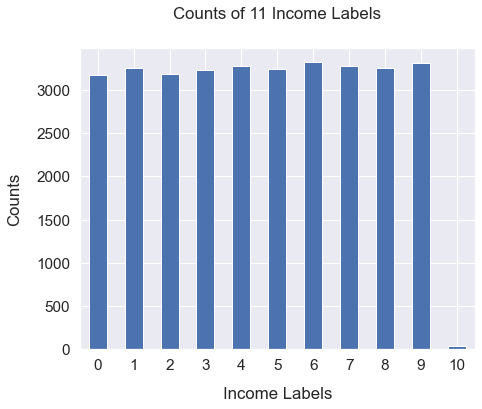

In [67]:
sns.set(font_scale=1.4)
y.value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Income Labels", labelpad=14)
plt.ylabel("Counts", labelpad=14)
plt.title("Counts of 11 Income Labels\n", y=1.02);
plt.tight_layout()
plt.show()

### 문제 27. Feature Engineering

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [69]:
X_train.columns

Index(['age', 'workclass', 'education.num', 'marital.status', 'occupation',
       'relationship', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week',
       'spend.groc', 'spend.med', 'spend.trav', 'asset', 'balance',
       'native.country'],
      dtype='object')

In [70]:
from sklearn import preprocessing

categorical = ['workclass', 'marital.status', 'occupation', 'relationship',
                'sex', 'native.country']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])

In [71]:
X_train[categorical].head()

,workclass,marital.status,occupation,relationship,sex,native.country
19749,4,2,3,0,1,39
1216,4,5,12,4,0,39
27962,4,2,7,0,1,7
23077,4,4,12,3,1,39
10180,6,2,1,5,0,39


### 문제 28. Light GBM 을 이용하여 다중분류 구현하기

In [72]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

lgbm =  LGBMClassifier()
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [74]:
lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### 문제 29. Light GBM  다중분류 결과  확인하기: Accuracy, Confusion Matrix, Heatmap

In [75]:
## 정확도 구하기
y_pred1 = lgbm.predict(X_test)

lgbm_score = accuracy_score(y_test, y_pred1)
print('LGBM Model accuracy score : {0:0.4f}'.format(lgbm_score))

LGBM Model accuracy score : 0.8220


In [76]:
pd.DataFrame(y_test).head(10)

,income.num
14160,6
27048,0
28868,1
5667,7
7827,5
15382,5
4641,8
8943,0
216,0
5121,7


In [77]:
pd.DataFrame(y_pred1).head(10)

,0
0,6
1,0
2,1
3,7
4,5
5,6
6,8
7,0
8,0
9,7


In [78]:
## Confusion Matrix 확인하기
from sklearn.metrics import confusion_matrix
cm1 =  confusion_matrix(y_test, y_pred1)
print('LGBM Confusion Matrix for 11-class Labels\n')
print(cm1)


LGBM Confusion Matrix for 11-class Labels

[[917  35   7   5   1   1   0   2   0   0   0]
 [ 39 861  35   9   0   3   1   2   1   1   0]
 [ 16  50 823  63  10   7   1   1   2   2   0]
 [  8  17  37 807  64  11   4   2   3   7   0]
 [  5  14  10  70 773  66  13   8   2   5   0]
 [  4   9   3  13  88 779  90  17  12   4   0]
 [ 14  13   4  17  21  65 737  83  12   8   0]
 [  7   7  11   4  14  20  86 707  85  22   0]
 [  4   5   5  11  13   9  11  54 793  82   0]
 [ 14  10   7  10  15   9  16  20  58 833   0]
 [  0   0   0   0   0   1   0   0   1  11   0]]


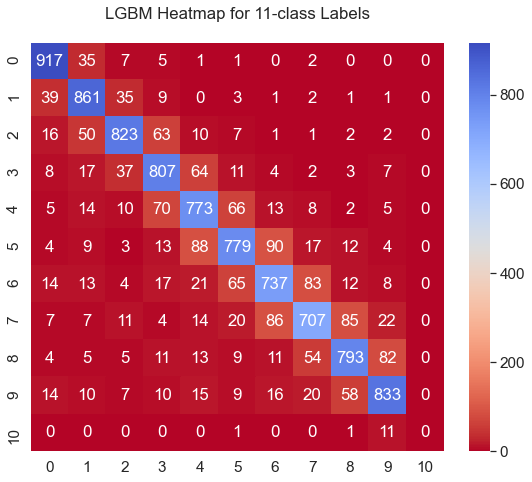

In [91]:
## 히트맵으로 시각화하기
plt.figure(figsize=[8,7])
sns.heatmap(cm1, annot=True, fmt='d', cmap='coolwarm_r')

plt.title('LGBM Heatmap for 11-class Labels\n')
plt.tight_layout()
plt.show()

In [84]:
print('LGBM Model accuracy score : {0:0.4f}'.format(lgbm_score))
print('\n')
print(classification_report(y_test, y_pred1))

## 상대적으로 5, 6, 7과 10 Class를 잘 못맞춰 
# 10을 9로 많이 예측함

LGBM Model accuracy score : 0.8220


              precision    recall  f1-score   support

           0       0.89      0.95      0.92       968
           1       0.84      0.90      0.87       952
           2       0.87      0.84      0.86       975
           3       0.80      0.84      0.82       960
           4       0.77      0.80      0.79       966
           5       0.80      0.76      0.78      1019
           6       0.77      0.76      0.76       974
           7       0.79      0.73      0.76       963
           8       0.82      0.80      0.81       987
           9       0.85      0.84      0.85       992
          10       0.00      0.00      0.00        13

    accuracy                           0.82      9769
   macro avg       0.75      0.75      0.75      9769
weighted avg       0.82      0.82      0.82      9769



### 문제 30. Random Forest 모델로 다중분류 구현하고 정확도 확인하기

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()  
rf.fit(X_train, y_train)

RandomForestClassifier()

In [96]:
y_pred = rf.predict(X_test)  
rf_score = accuracy_score(y_test, y_pred)
print('Random Forest Model accuracy score : {0:0.4f}'. format(rf_score))
print()
print('Classification Report Using RandomForest')
print(classification_report(y_test, y_pred))

Random Forest Model accuracy score : 0.7703

Classification Report Using RandomForest
              precision    recall  f1-score   support

           0       0.86      0.96      0.90       968
           1       0.80      0.87      0.83       952
           2       0.79      0.80      0.80       975
           3       0.77      0.79      0.78       960
           4       0.75      0.76      0.75       966
           5       0.75      0.70      0.72      1019
           6       0.71      0.72      0.72       974
           7       0.71      0.68      0.69       963
           8       0.75      0.70      0.72       987
           9       0.81      0.75      0.78       992
          10       0.00      0.00      0.00        13

    accuracy                           0.77      9769
   macro avg       0.70      0.70      0.70      9769
weighted avg       0.77      0.77      0.77      9769



## Step 7. 다중분류 모델의 평가와 개선

모델 개선 --> 정확도/F1 스코어 개선 <-- 모델 변경, 파라미터 변경, 데이터 변경(처리, feature engineering, 정제, 아웃라이어 제거, 변수 추가) 11개 --> ?개

### 문제 31. Random Forest 다중분류 모델의 정확도 확인하기

In [97]:
## 이전 Step 복습
y_pred = rf.predict(X_test)
rf_score = accuracy_score(y_test, y_pred)
print('Randoom Forest Model accuracy score : {0:0.4f}'. format(rf_score)) 

## 평가 방법 : 정확도(exact match), <-- 분류 레이블의 임의성, 불명확성 // 레이블의 구분을 달리하면 결과가 달라질수있음

Randoom Forest Model accuracy score : 0.7703


### 문제 32. Random Forest  다중분류 모델의 인접정확도 구하기

In [98]:
## 인접 정확도의 계산
precise_accuracy = np.sum(y_pred == y_test) / len(y_pred)
adjacent_accuracy = np.sum(np.abs(y_pred - y_test) <= 1) / len(y_pred)

print('precise accuracy: {0:0.4f}'. format(precise_accuracy))
print('adjacent accuracy: {0:0.4f}'. format(adjacent_accuracy))

precise accuracy: 0.7703
adjacent accuracy: 0.9288


### 문제 33. Random Forest  다중분류 모델의 Confusion Matrix 확인하기

In [99]:
print(cm1) # light gbm 

[[917  35   7   5   1   1   0   2   0   0   0]
 [ 39 861  35   9   0   3   1   2   1   1   0]
 [ 16  50 823  63  10   7   1   1   2   2   0]
 [  8  17  37 807  64  11   4   2   3   7   0]
 [  5  14  10  70 773  66  13   8   2   5   0]
 [  4   9   3  13  88 779  90  17  12   4   0]
 [ 14  13   4  17  21  65 737  83  12   8   0]
 [  7   7  11   4  14  20  86 707  85  22   0]
 [  4   5   5  11  13   9  11  54 793  82   0]
 [ 14  10   7  10  15   9  16  20  58 833   0]
 [  0   0   0   0   0   1   0   0   1  11   0]]


In [100]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_test, y_pred)
print('Random Forest Confusion Matrix for 11-class Labels\n')
print(cm2)

Random Forest Confusion Matrix for 11-class Labels

[[925  33   6   1   1   0   1   0   1   0   0]
 [ 56 826  60   5   1   3   0   1   0   0   0]
 [ 28  80 780  70  10   2   1   1   1   2   0]
 [ 13  21  73 759  66  15   4   1   4   4   0]
 [  6  19  19  78 731  83  14   6   4   6   0]
 [  8   7  12  16 121 717 111  19   6   2   0]
 [ 17  15  10  17  16  80 704  97   8  10   0]
 [  8  11   6   9  11  25 110 653  99  31   0]
 [  4   9   9   9  14  16  23 106 687 110   0]
 [ 16  11  11  18  10  19  20  40 104 743   0]
 [  0   0   0   0   0   1   0   0   1  11   0]]


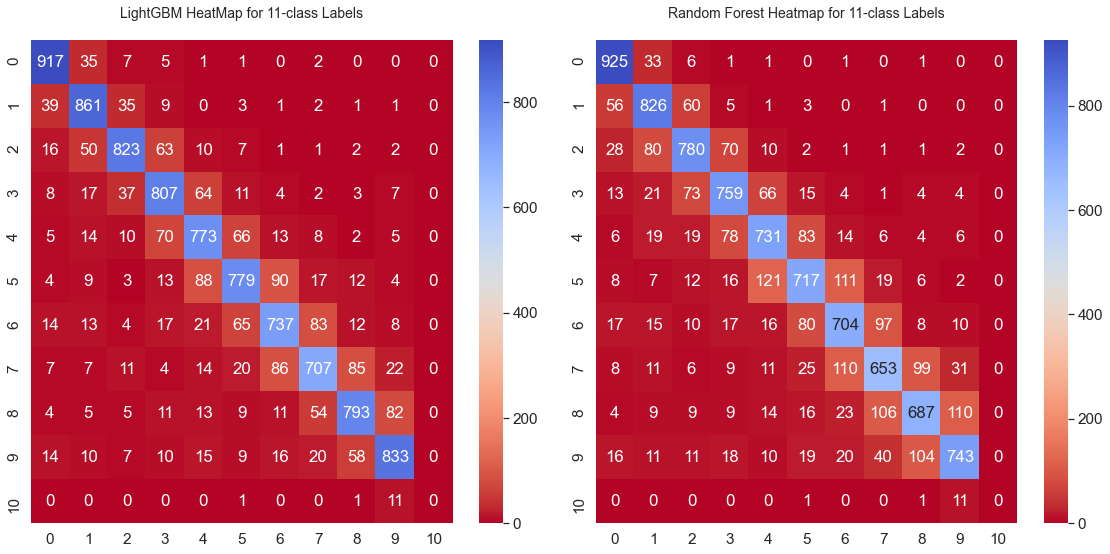

In [108]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.heatmap(cm1, annot=True, fmt='d', cmap='coolwarm_r', ax=axes[0])
axes[0].set_title('LightGBM HeatMap for 11-class Labels\n', fontsize=14)

sns.heatmap(cm2, annot=True, fmt='d', cmap='coolwarm_r', ax=axes[1])
axes[1].set_title('Random Forest Heatmap for 11-class Labels\n', fontsize=14)
plt.tight_layout()
plt.show()

### 문제 34. Random Forest  다중분류 모델의 분류결과 확인하기

In [104]:
from sklearn.metrics import classification_report

print('Random Forest precise  accuracy for 11 labels: {0:0.4f}'. format(precise_accuracy)) 
print('Random Forest adjacent accuracy for 11 labels: {0:0.4f}'. format(adjacent_accuracy))
print('\n')
print(classification_report(y_test, y_pred))

Random Forest precise  accuracy for 11 labels: 0.7703
Random Forest adjacent accuracy for 11 labels: 0.9288


              precision    recall  f1-score   support

           0       0.86      0.96      0.90       968
           1       0.80      0.87      0.83       952
           2       0.79      0.80      0.80       975
           3       0.77      0.79      0.78       960
           4       0.75      0.76      0.75       966
           5       0.75      0.70      0.72      1019
           6       0.71      0.72      0.72       974
           7       0.71      0.68      0.69       963
           8       0.75      0.70      0.72       987
           9       0.81      0.75      0.78       992
          10       0.00      0.00      0.00        13

    accuracy                           0.77      9769
   macro avg       0.70      0.70      0.70      9769
weighted avg       0.77      0.77      0.77      9769



### 문제 35. 적절한 클래스 수로 변환하여 모델 개선하기

In [109]:
## Define new function
def value_change(x):
    if x <= 20000: return 0
    if x >  20000 and x <= 50000 : return 1
    if x >  50000 and x <= 70000 : return 2
    if x >  70000 and x <= 90000 : return 3 
    return 4

## Apply Lambda function
y = data['income.num'].apply(lambda x: value_change(x)) 

In [110]:
y.value_counts()

1    9686
2    6564
3    6533
0    6426
4    3352
Name: income.num, dtype: int64

In [111]:
y.value_counts().sum()

32561

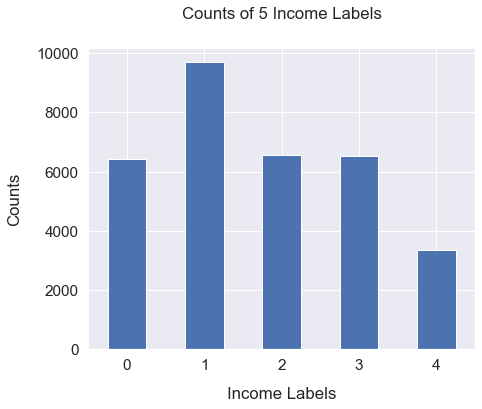

In [113]:
sns.set(font_scale=1.4)
y.value_counts().plot(kind='bar', figsize=(7, 6), rot=0)

plt.xlabel("Income Labels", labelpad=14)
plt.ylabel("Counts", labelpad=14)
plt.title("Counts of 5 Income Labels\n", y=1.02);

plt.tight_layout()
plt.show()

### 문제 36. Feature Engineering

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [115]:
from sklearn import preprocessing

categorical = ['workclass', 'marital.status', 'occupation', 'relationship', 'sex', 'native.country']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])

### 문제 37. 변경한 클래스를 이용한 Random Forest 다중분류 모델의 개선결과 확인하기

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [117]:
## Confusion Matrix 확인하기
y_pred = rf.predict(X_test)
cm3 = confusion_matrix(y_test, y_pred)
print('Random Forest Confusion Matrix for 5-class Labels\n')
print(cm3)

Random Forest Confusion Matrix for 5-class Labels

[[1811  144    2    0    0]
 [ 105 2721   84    8    0]
 [  31  194 1609  118    1]
 [  26   81  134 1680   39]
 [  13   56   29  253  630]]


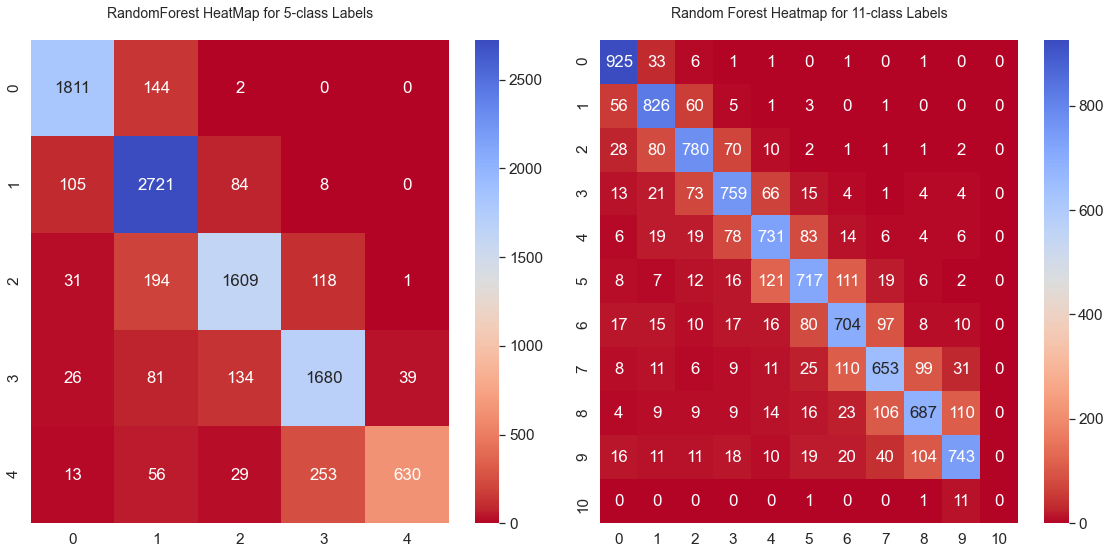

In [124]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.heatmap(cm3, annot=True, fmt='d', cmap='coolwarm_r', ax=axes[0])
axes[0].set_title('RandomForest HeatMap for 5-class Labels\n', fontsize=14)

sns.heatmap(cm2, annot=True, fmt='d', cmap='coolwarm_r', ax=axes[1])
axes[1].set_title('Random Forest Heatmap for 11-class Labels\n', fontsize=14)
plt.tight_layout()
plt.show()

In [120]:
## Accruacy Evaluation
precise_accuracy =  np.sum(y_test == y_pred) / len(y_test)
adjacent_accuracy =   np.sum(np.abs(y_test - y_pred) <= 1) / len(y_test)

print('precise accuracy: {0:0.4f}'. format(precise_accuracy))
print('adjacent accuracy: {0:0.4f}'. format(adjacent_accuracy))

precise accuracy: 0.8651
adjacent accuracy: 0.9747


In [121]:
## 2가지 Accruacy 스코어의 비교
print('Random Forest precise  accuracy for 5 labels: {0:0.4f}'. format(precise_accuracy))
print('Random Forest adjacent accuracy for 5 labels: {0:0.4f}'. format(adjacent_accuracy))
print('\n')
print(classification_report(y_test, y_pred))

Random Forest precise  accuracy for 5 labels: 0.8651
Random Forest adjacent accuracy for 5 labels: 0.9747


              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1957
           1       0.85      0.93      0.89      2918
           2       0.87      0.82      0.84      1953
           3       0.82      0.86      0.84      1960
           4       0.94      0.64      0.76       981

    accuracy                           0.87      9769
   macro avg       0.88      0.84      0.85      9769
weighted avg       0.87      0.87      0.86      9769



### 문제 38. 변경한 클래스를 이용한 Ligth GBM 다중분류 모델의 개선결과 확인하기

In [122]:
lgbm = LGBMClassifier(random_state=0)
lgbm.fit(X_train, y_train)
y_pred1 = lgbm.predict(X_test)

lgbm_score1 = accuracy_score(y_test, y_pred1)
print('LGBM Model accuracy score : {0:0.4f}'.format(lgbm_score1))

LGBM Model accuracy score : 0.9030


In [123]:
## Confusion Matrix 구하기

cm4 = confusion_matrix(y_test, y_pred1)
print('LGBM Confusion Matrix for 5-class Labels\n')
print(cm4)

LGBM Confusion Matrix for 5-class Labels

[[1858   93    2    4    0]
 [  75 2756   70   13    4]
 [  26  129 1700   95    3]
 [  24   54  106 1717   59]
 [  13   35   24  119  790]]


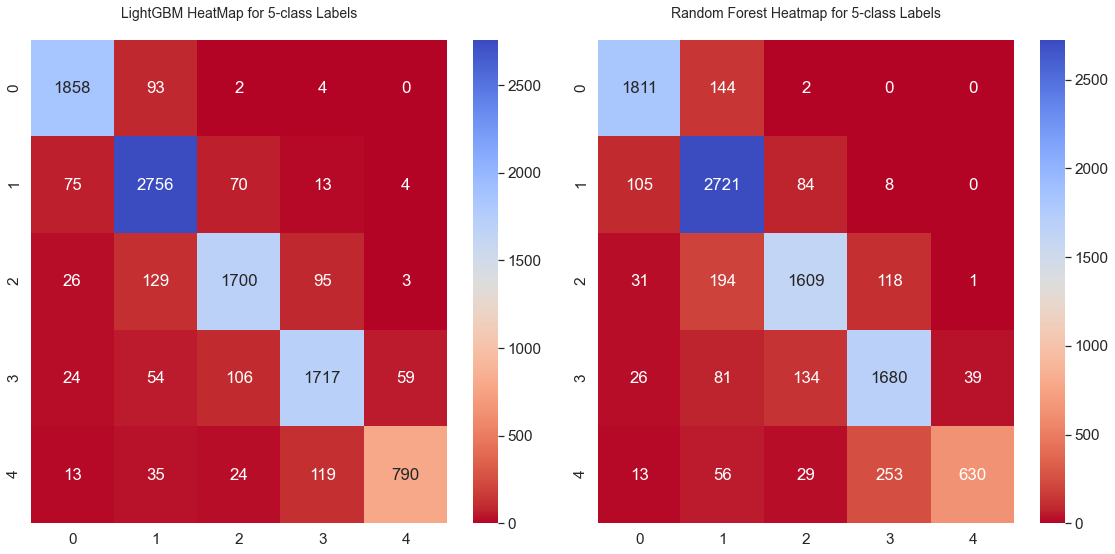

In [125]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.heatmap(cm4, annot=True, fmt='d', cmap='coolwarm_r', ax=axes[0])
axes[0].set_title('LightGBM HeatMap for 5-class Labels\n', fontsize=14)

sns.heatmap(cm3, annot=True, fmt='d', cmap='coolwarm_r', ax=axes[1])
axes[1].set_title('Random Forest Heatmap for 5-class Labels\n', fontsize=14)
plt.tight_layout()
plt.show()

In [126]:
## Accuracy Evalaution
precise_accuracy1 =  np.sum(y_test == y_pred1) / len(y_test) # exact score
adjacent_accuracy1 =   np.sum(np.abs(y_test - y_pred1) <= 1) / len(y_test) # adjacent score

print('LGBM precise  accuracy for 5 labels: {0:0.4f}'. format(precise_accuracy1))
print('LGBM adjacent accuracy for 5 labels: {0:0.4f}'. format(adjacent_accuracy1))
print('\n')
print(classification_report(y_test, y_pred1))

LGBM precise  accuracy for 5 labels: 0.9030
LGBM adjacent accuracy for 5 labels: 0.9793


              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1957
           1       0.90      0.94      0.92      2918
           2       0.89      0.87      0.88      1953
           3       0.88      0.88      0.88      1960
           4       0.92      0.81      0.86       981

    accuracy                           0.90      9769
   macro avg       0.91      0.89      0.90      9769
weighted avg       0.90      0.90      0.90      9769



### 문제 39. 요약: 소득 다중분류 예측모델의 결과 비교하기

In [127]:
print('Accuracy Comparisons for Multiclass Models\n')
print('rfc_score  (11 labels)  :', '{0:0.5f}'.format(rf_score)) # Step 6, 문제 30
print('rfc_score  ( 5 labels)  :', '{0:0.5f}'.format(precise_accuracy)) # Step 7, 문제 32
print('lbgm_score (11 labels)  :', '{0:0.5f}'.format(lgbm_score)) # Step 6, 문제 29
print('lgbm_score ( 5 labels)  :', '{0:0.5f}'.format(precise_accuracy1)) # Step 7, 문제 38

# 모델을 바꿨을 때 개선되는 정확도보다 데이터 처리를 어떻게 하는지가 더 영향을 많이 준다.
# 데이터 처리 제일 중요!!

Accuracy Comparisons for Multiclass Models

rfc_score  (11 labels)  : 0.77029
rfc_score  ( 5 labels)  : 0.86508
lbgm_score (11 labels)  : 0.82199
lgbm_score ( 5 labels)  : 0.90296


In [128]:
print('LGBM Confusion Matrix')
print(cm1) # Step 6, 문제 29
print('\n')
print('Random Forest Confusion Matrix')
print(cm2) # Step 7, 문제 33

LGBM Confusion Matrix
[[917  35   7   5   1   1   0   2   0   0   0]
 [ 39 861  35   9   0   3   1   2   1   1   0]
 [ 16  50 823  63  10   7   1   1   2   2   0]
 [  8  17  37 807  64  11   4   2   3   7   0]
 [  5  14  10  70 773  66  13   8   2   5   0]
 [  4   9   3  13  88 779  90  17  12   4   0]
 [ 14  13   4  17  21  65 737  83  12   8   0]
 [  7   7  11   4  14  20  86 707  85  22   0]
 [  4   5   5  11  13   9  11  54 793  82   0]
 [ 14  10   7  10  15   9  16  20  58 833   0]
 [  0   0   0   0   0   1   0   0   1  11   0]]


Random Forest Confusion Matrix
[[925  33   6   1   1   0   1   0   1   0   0]
 [ 56 826  60   5   1   3   0   1   0   0   0]
 [ 28  80 780  70  10   2   1   1   1   2   0]
 [ 13  21  73 759  66  15   4   1   4   4   0]
 [  6  19  19  78 731  83  14   6   4   6   0]
 [  8   7  12  16 121 717 111  19   6   2   0]
 [ 17  15  10  17  16  80 704  97   8  10   0]
 [  8  11   6   9  11  25 110 653  99  31   0]
 [  4   9   9   9  14  16  23 106 687 110   0]
 [ 1

In [129]:
print ('Classification Comparions for Multiclass Models\n')
print ('rfc_score   :', '{0:0.4f}'.format(rfc_score))
print (classification_report(y_test, y_pred)) # Step 7, 문제 37
print ('lgbm_score  :', '{0:0.4f}'.format(lgbm_score))
print (classification_report(y_test, y_pred1))

Classification Comparions for Multiclass Models

rfc_score   : 0.7703
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1957
           1       0.85      0.93      0.89      2918
           2       0.87      0.82      0.84      1953
           3       0.82      0.86      0.84      1960
           4       0.94      0.64      0.76       981

    accuracy                           0.87      9769
   macro avg       0.88      0.84      0.85      9769
weighted avg       0.87      0.87      0.86      9769

lgbm_score  : 0.8220
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1957
           1       0.90      0.94      0.92      2918
           2       0.89      0.87      0.88      1953
           3       0.88      0.88      0.88      1960
           4       0.92      0.81      0.86       981

    accuracy                           0.90      9769
   macro avg       0.91      0.89      0

## Step 8. 요약

- 1) 이진분류·다중분류 모델의 이해<p>: 분류 항목의 수에 따라 달라지는 모델링 방법(파라미터 처리)

- 2) 선형 기반·트리 기반 분류모델의 이해<p>: Logistic Regression, Random Forest, Gradient Boosting, <strong>Light GBM</strong> 등


- 3) 변수 처리 방법에 대한 이해<p>: 범주변수 처리, 스케일 조정, 3개 이상의 클래스 처리


- 4) 분류모델 결과를 해석하는 방법 습득<p>: 단순정확도, <b>인접정확도</b>, Precision, Recall  등


- 5) 평가결과를 바탕으로 모델을 개선하는 방법 습득<p>: F1 스코어, Confusion Matrix, Classification Report 등을 종합적으로 이용
    

- 다음 주제: 구현한 머신러닝 모델을 XAI 기법으로 설명하기